In [ ]:
!pip install pysatproc
!pip install unetseg

In [ ]:
!pip install --force-reinstall numpy==1.20

In [ ]:
!pip install unetseg

# 2_ Predicción

In [12]:

#General
version = "v1"
type_image = "s2"
year = "2020"

###########
## SULA 
###########
zone = "sula" 
size = 80
step_size = size
#satproc
PATH_images_predict = '../images/S2/'+zone
aoi_pred = "ciudad_san_pedro_sula.geojson"

#train
info = "classA"
#unet
CLASS_WEIGHT = [1]
STEP_PER_EPOCH = 100
N_CLASSES = 1

#post-process
thr=0.3
min_area = 50000

###########
## TEGU 
###########

#zone = "tegu"
#size =80
#step_size = 40
##satproc
#PATH_images_train = '../images/S2/'+zone
#gt_file = "anotaciones_lowresolution_small_4326.geojson"
#CLASSES = 'A' 'B' 'C'
##train
#info = "classABC_gtlowreso"
##unet
#CLASS_WEIGHT = [0.2,0.3,0.5]
#STEP_PER_EPOCH = 100
#N_CLASSES = 3

##post-process
#threshold_A = 50
#threshold_B = 15
#threshold_C = 15
#min_area = 100000
#DEBUG = False



## Generación del data set de predicción

Descarga las imagenes del bucket

In [ ]:
#PATH_s1_images_predict = ""

#!mkdir -p $PATH_s1_images_predict

#bucket = "gs://" 
#!gsutil -m cp -r $bucket $PATH_s1_images_predict

In [ ]:
#!gdalbuildvrt *.vrt *.tif

### Satproc

Con esta herramienta genereamos un dataset de imágenes de predicción que, a diferencia del de entrenamiento, solo contiene imágenes.

Pasamos la ruta de las imágenes de predicción y la ruta donde queremos que se guarde el resultado.



In [2]:
path_to_files   = PATH_images_predict + "/*.tif" #carpeta a las imagenes
output_folder   = '../dataset/data_predict/'+type_image+'/'+zone+'/'+year+'/'+str(size)+'_'+str(step_size)+'/' #carpeta de destino del dataset
vector_file_aoi = "../data/shp/"+ aoi_pred #archivo vectorial con las zonas de interes

*Obs*: Dado que aquí nos interesa predecir sobre toda la imágen y por ende no tener overlaps,  *step_size* debe ser igual a *size*.

In [ ]:
#!satproc_extract_chips --help

In [3]:
!satproc_extract_chips \
                $path_to_files \
                -o  $output_folder \
                --size $size \
                --step-size $step_size \
                --aoi $vector_file_aoi \
                --rescale \
                --rescale-mode values --min 0 --max 0.3

Rasters: 100%|####################################| 1/1 [00:01<00:00,  1.49s/it]


## Prediccion

In [4]:
from unetseg.predict import PredictConfig, predict
from unetseg.evaluate import plot_data_results
import os

2022-04-19 12:39:08.344911: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/cv2/../../lib64:
2022-04-19 12:39:08.344944: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Definimos la configuración para la predicción. Debemos pasar la ruta de las imágenes en el dataset de predicción, que es la ruta de salida de la línea anterior, y la correspondiente al modelo que entrenamos.

In [13]:

model_name = 'UNet_'+type_image+'_160x160_'+str(size)+'_40_spe100_3N_spe100_fecha'+year+'_lugar'+zone+'_'+info+'_'+version+'.h5'

predict_config = PredictConfig(
                            images_path=os.path.join('../dataset/data_predict',type_image,zone,year,str(size)+"_"+str(step_size)), # ruta a las imagenes sobre las cuales queremos predecir
                            results_path=os.path.join('../dataset/data_results',version,type_image,zone,year,str(size)+"_"+str(step_size)), # ruta de destino para nuestra predicción
                            batch_size=16,
                            model_path=os.path.join('../data/weights',model_name),  #  ruta al modelo (.h5)
                            height=160,
                            width=160,
                            n_channels = 3,
                            n_classes  = N_CLASSES,
                            class_weights = CLASS_WEIGHT)


A continuación ejecutamos la predicción .

In [6]:
predict(predict_config)  # Ejecuta la predicción

Total images to predict (../dataset/data_predict/s2/sula/2020/130_130/images/*.tif): 263
After skipping existing results: 263


2022-04-19 12:39:13.510000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 12:39:13.510868: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/cv2/../../lib64:
2022-04-19 12:39:13.511007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/cv2/../../lib64:
2022-04-19 12:39:13.511096: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'

Done!


In [27]:
#!ls ../data/weights/

Podemos ver algunos resultados preliminares de la predicción. A la izquierda se encuentra la imágen y a la derecha, la predicción.

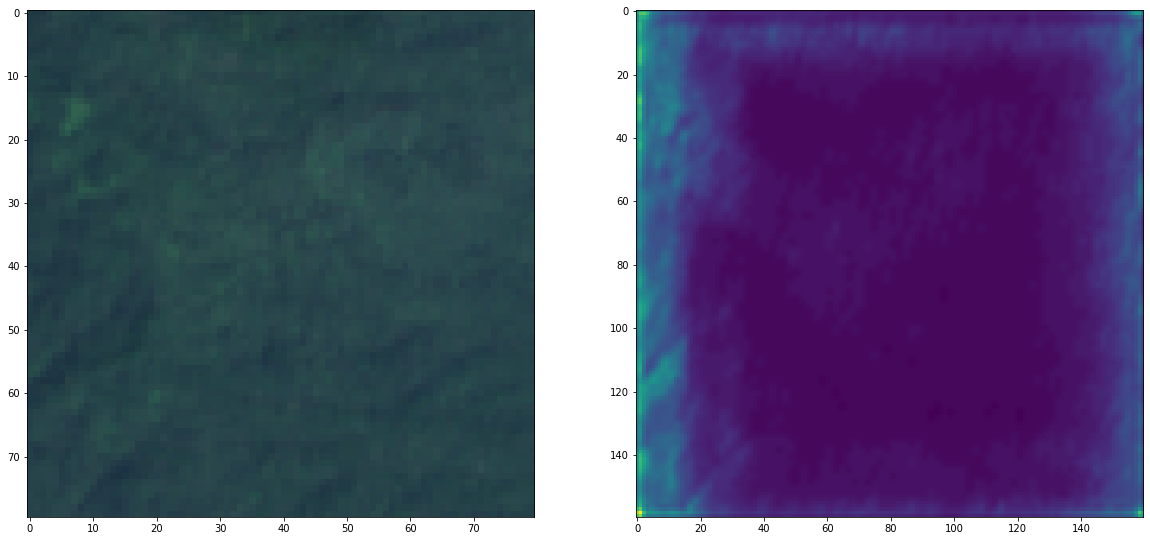

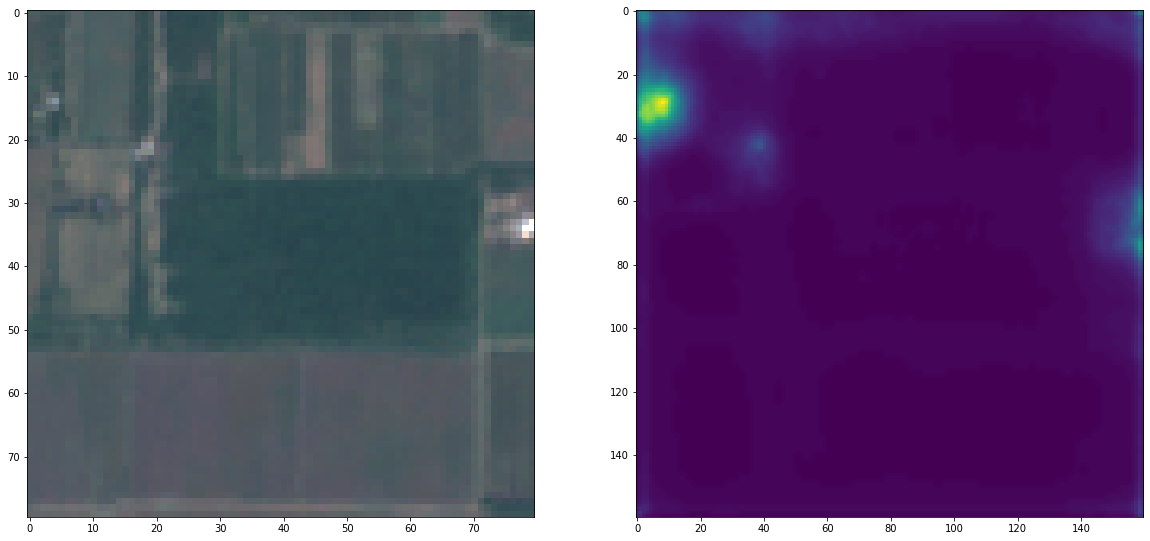

In [14]:
plot_data_results(num_samples=2, fig_size=(2, 2), predict_config=predict_config, img_ch =2, n_bands=3)

## Post procesamiento 3 clases

En esta etapa se aplican los siguientes métodos de post-procesamiento a los resultados de la predicción realizada por el modelo:

* Filtrado por umbral
* Poligonizado

## Filtrado por umbral
En este proceso se realiza un filtrado de las imágenes mediante la aplicación de un umbral sobre los valores de los rásteres, que en este caso representan la probabilidad (valores entre 0 y 1), quedandonos así con las de mayor precisión.

In [32]:
from tqdm import tqdm
import subprocess
import os
from satproc.postprocess.polygonize import polygonize 
from satproc.filter import filter_by_max_prob

if N_CLASSES==3:

    results_path = os.path.join('../dataset/data_results',version,type_image,zone,year,str(size)+"_"+str(step_size)+'/')
    if DEBUG: print (results_path)

    dest = os.path.join('../dataset/data_results/temp_postprocesamiento',type_image+'_'+zone+"_"+year+"_"+str(size)+"_"+str(step_size)) # ruta de destino para nuestra predicción
    if DEBUG: print (dest)

    files = next(os.walk(results_path))[2]
    new_dir = os.path.join(dest, '1band_3classes','thr_'+str(threshold_A)+'_'+str(threshold_B)+'_'+str(threshold_C))
    os.makedirs(new_dir, exist_ok=True)
    if DEBUG: print (new_dir)
    for file in files:
        if os.path.splitext(file)[-1]=='xml': continue

        result_dst = os.path.join(results_path,file)
        output_tif_path = os.path.join(dest, '1banda_3clases/','thr_'+str(threshold_A)+'_'+str(threshold_B)+'_'+str(threshold_C), file)
        exp = "((B<"+str(threshold_B)+")*(C<"+str(threshold_C)+")*(A >"+str(threshold_A)+")*199 ) + ((C<"+str(threshold_C)+")*(B >"+str(threshold_B)+")*99 )+((B<"+str(threshold_B)+")*(C >"+str(threshold_C)+")*254 ) +1"
        cmd_calc = f'gdal_calc.py -A {result_dst} --A_band=1 -B {result_dst} --B_band=2 -C {result_dst} --C_band=3 --outfile {output_tif_path} --calc="{exp}" --NoDataValue=0'
        subprocess.run(cmd_calc, shell=True)
        print("--",output_tif_path)
    print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")    
    output_vrt = os.path.join(dest, '1banda_3clases','thr_'+str(threshold_A)+'_'+str(threshold_B)+'_'+str(threshold_C),'tiles.vrt')
    output_tif = os.path.join(dest, '1banda_3clases','thr_'+str(threshold_A)+'_'+str(threshold_B)+'_'+str(threshold_C),'*.tif')
    cmd_buildvrt = f'gdalbuildvrt {output_vrt} {output_tif}'
    subprocess.run(cmd_buildvrt, shell=True)
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")   
    output_shp_path = os.path.join('../dataset/data_results', 'poligonize_classABC_thr_'+str(threshold_A)+'_'+str(threshold_B)+'_'+str(threshold_C)+'_'+zone+'_'+year+'_'+type_image+'_'+str(size)+'_'+str(step_size)+'_'+version+'.gpkg')
    cmd_polygonize = f'gdal_polygonize.py {output_vrt} {output_shp_path}'
    subprocess.run(cmd_polygonize, shell=True)

if N_CLASSES==1:

    str_thr = str(int(thr *10))

    input_path =  os.path.join('../dataset/data_results',version,type_image,zone,year,str(size)+"_"+str(step_size)+'/')
    output_file = os.path.join('../dataset/data_results/poligonize_thr_'+str_thr+'_'+zone+'_'+year+'_'+type_image+'_'+str(size)+'_'+str(step_size)+'_'+version+'.gpkg') # ruta de destino para nuestra predicción

    polygonize(threshold=thr, input_dir=input_path, output=output_file)

0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_21_15.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_14_18.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_4_16.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_4_8.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_13_28.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_18_24.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80

0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_15_22.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_24_20.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_18_11.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_11_2.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_24_10.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_23_20.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_

0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_13_17.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_5_20.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_16_7.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_0_4.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_21_24.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_8_23.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1

0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_24_9.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_24_28.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_5_4.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_24_14.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_8_24.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_3_10.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1

0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_18_9.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_9_5.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_2_4.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_19_26.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_7_0.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_4_11.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1ban

0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_8_18.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_9_0.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_3_28.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_24_25.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_3_17.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_10_12.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1

0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_19_3.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_12_17.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_4_10.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_3_20.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_2_7.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_16_9.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1b

0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_19_27.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_3_5.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_11_0.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_16_19.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_23_7.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_8_1.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1b

0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_22_6.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_17_24.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_2_2.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_24_16.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_11_15.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_23_28.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80

0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_22_13.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_10_10.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_6_8.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_11_13.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_17_6.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_5_18.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/

0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_1_9.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_13_11.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_10_7.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_9_3.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_3_8.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_8_12.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1ban

ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRaste

ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRasterBand is not supported.
ERROR 1: Writing through VRTSourcedRaste

0.. 0.. 0.. 1.. 1.. 1.. 2.. 2.. 2.. 3.. 3.. 3.. 4.. 4.. 4.. 5.. 5.. 5.. 6.. 6.. 6.. 7.. 7.. 7.. 8.. 8.. 9.. 9.. 9.. 10.. 10.. 10.. 11.. 11.. 11.. 12.. 12.. 12.. 13.. 13.. 13.. 14.. 14.. 14.. 15.. 15.. 15.. 16.. 16.. 17.. 17.. 17.. 18.. 18.. 18.. 19.. 19.. 19.. 20.. 20.. 20.. 21.. 21.. 21.. 22.. 22.. 22.. 23.. 23.. 23.. 24.. 24.. 25.. 25.. 25.. 26.. 26.. 26.. 27.. 27.. 27.. 28.. 28.. 28.. 29.. 29.. 29.. 30.. 30.. 30.. 31.. 31.. 31.. 32.. 32.. 32.. 33.. 33.. 34.. 34.. 34.. 35.. 35.. 35.. 36.. 36.. 36.. 37.. 37.. 37.. 38.. 38.. 38.. 39.. 39.. 39.. 40.. 40.. 40.. 41.. 41.. 42.. 42.. 42.. 43.. 43.. 43.. 44.. 44.. 44.. 45.. 45.. 45.. 46.. 46.. 46.. 47.. 47.. 47.. 48.. 48.. 48.. 49.. 49.. 50.. 50.. 50.. 51.. 51.. 51.. 52.. 52.. 52.. 53.. 53.. 53.. 54.. 54.. 54.. 55.. 55.. 55.. 56.. 56.. 56.. 57.. 57.. 57.. 58.. 58.. 59.. 59.. 59.. 60.. 60.. 60.. 61.. 61.. 61.. 62.. 62.. 62.. 63.. 63.. 63.. 64.. 64.. 64.. 65.. 65.. 65.. 66.. 66.. 67.. 67.. 67.. 68.. 68.. 68.. 69.. 69.. 69.. 70.. 70.. 70.. 71..

0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_19_7.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_13_6.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_13_25.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_13_3.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_11_23.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_19_14.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80

0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_20_24.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_5_26.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_23_15.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_22_26.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_23_18.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/0000000000-0000000000_1_13.tif
0.. 33.. 66.. 100 - Done
-- ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_8

CompletedProcess(args='gdal_polygonize.py ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/1banda_3clases/thr_50_15_15/tiles.vrt ../dataset/data_results/v1/postprocesamiento/s2_tegu_2020_80_80/tegu_classABC_thr_50_15_15.gpkg', returncode=0)

### Filtro de area minima

In [19]:
src_file =output_file
dst_file = output_file[:-5] + '_utm.gpkg'

!ogr2ogr -s_srs EPSG:4326 -t_srs EPSG:32720 -f 'GPKG' $dst_file $src_file


tabla = os.path.basename(output_file)[:-5]

input_path = dst_file
output_path = dst_file[:-5]+ "_up"+str(min_area)+".gpkg"


!ogr2ogr \
    -t_srs EPSG:32720 \
    -f "GPKG" \
    -sql "SELECT * FROM $tabla m WHERE (ST_Area(geom) > $min_area)" \
    -dialect SQLITE \
    -nln results \
    $output_path \
    $input_path

../dataset/data_results/poligonize_thr_3_sula_2020_s2_80_80_v1.gpkg
../dataset/data_results/poligonize_thr_3_sula_2020_s2_80_80_v1_utm.gpkg
